## Create a Random Forest Regression Model
### Explore the following:
- Creating a Random Forest Regression model that predicts housing prices. 
- kflods
- GridSearchCV


- Would like to add
    - How accurate is the model? 
    - At what percentage does it predict within the actual range?
    - python pipeline
    - compare with k-nn

#### Instructions:
- find data set
- set # of trees to 100
- choose k'(prime)
- graph MSE - y axis
- number of trees on x axis 


#### Notes about code below:
- uses model_selection import KFold
    - built in kfold library creates the folds, can easily reproduce the same folds and selection and iterate over
- remember for classification problems outcome is between 0 and 1
- for continuous regression, outcome is still a probability but on a continuous scale.
- for creating data, good choices are:
    - np.random.choice
    - np.random.rand
    - np.random.randint
    - np.random.normal
- To convert a dataframe to np array use df.as_matrix(), I selected the columns first then converted.
- remember sklearn works with np not pd.
- Once we reach a large enough forest of trees, MSE will not get better.
- When more trees are added, MSE will not go up, it will only go down or remain level.
- for convenience to iterate across all parameters use model_selection import GridSerchCV
    - scoring we will use neg_mean_squared_error.
       - converts to negative, because when plotting, the higher the number the better for visual effect
       - It's how sklearn handles mse and other scoring. 
- relative importance plot of feature importance.
- We can then relate features against support into a line plot across a single feature
    - Called a partial dependency plot
- we can then relate features together between them to uncover relationships
- sklearn.pipeline import Pipeline
    - standardize and transform data
    - allows iteration through multiple projects quickly
        - facilites easy exploration of tuning parameters
- When creating effect curve, use fit data
    - because want to know how it changes over prediction, aka effect of prediction.


    

    

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv('dataset/kc_house_data.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [2]:
# pd.get_dummies(df[['zipcode']], prefix='zip-')

In [3]:
# get a subset of the data and convert to np.
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'condition', 'sqft_lot', 'waterfront', 'view', 'zipcode']].as_matrix()
Y = df['price']


#convert the zip code to categorical data.

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# labelencoder_X = LabelEncoder()
x_copy = X.copy()
# X[:, 7] = labelencoder_X.fit_transform(X[:, 7])

#It was not required for me to first transform the label into a numeric value using labelencoder because 
# the zip codes are already numbers ready to transform into categories. 
# had the column been states or another non numeric type value, then, yes, first step is labelencoder.
onehotencoder = OneHotEncoder(categorical_features = [7])
X = onehotencoder.fit_transform(X).toarray()

#create a list of labels for use later in matching results to appropriate column.
label_list = onehotencoder.active_features_.tolist() + \
                            ['bedrooms', 'bathrooms', 'sqft_living', 'condition', \
                             'sqft_lot', 'waterfront', 'view']

# # Encoding the Dependent Variable
# labelencoder_y = LabelEncoder()
# Y = labelencoder_y.fit_transform(Y)

In [4]:
print(X.shape)
print(len(label_list))


(21613, 77)
77


In [5]:
print(X[0:3,4:70])
print(X[0:3,7:20])
print(X.shape)
print(X[0:3, -3])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]
(21613, 77)
[ 

In [7]:
onehotencoder = OneHotEncoder(categorical_features = [7])
tmp_x = onehotencoder.fit_transform(x_copy).toarray()
print(tmp_x.shape)
print(onehotencoder.active_features_)
print(type(onehotencoder.active_features_))
onehotencoder.active_features_.tolist()

(21613, 77)
[98001 98002 98003 98004 98005 98006 98007 98008 98010 98011 98014 98019
 98022 98023 98024 98027 98028 98029 98030 98031 98032 98033 98034 98038
 98039 98040 98042 98045 98052 98053 98055 98056 98058 98059 98065 98070
 98072 98074 98075 98077 98092 98102 98103 98105 98106 98107 98108 98109
 98112 98115 98116 98117 98118 98119 98122 98125 98126 98133 98136 98144
 98146 98148 98155 98166 98168 98177 98178 98188 98198 98199]
<class 'numpy.ndarray'>


[98001,
 98002,
 98003,
 98004,
 98005,
 98006,
 98007,
 98008,
 98010,
 98011,
 98014,
 98019,
 98022,
 98023,
 98024,
 98027,
 98028,
 98029,
 98030,
 98031,
 98032,
 98033,
 98034,
 98038,
 98039,
 98040,
 98042,
 98045,
 98052,
 98053,
 98055,
 98056,
 98058,
 98059,
 98065,
 98070,
 98072,
 98074,
 98075,
 98077,
 98092,
 98102,
 98103,
 98105,
 98106,
 98107,
 98108,
 98109,
 98112,
 98115,
 98116,
 98117,
 98118,
 98119,
 98122,
 98125,
 98126,
 98133,
 98136,
 98144,
 98146,
 98148,
 98155,
 98166,
 98168,
 98177,
 98178,
 98188,
 98198,
 98199]

In [8]:
# print(tmp_x[0:10,0:76])
# print(x_copy[0:10,7])
tmp_bool = tmp_x[0:10,0:70]==1
# print(tmp_bool)
# print([onehotencoder.active_features_[val] for val in tmp_bool])
onehotencoder.active_features_

array([98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010,
       98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029,
       98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042,
       98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070,
       98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106,
       98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119,
       98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155,
       98166, 98168, 98177, 98178, 98188, 98198, 98199])

20359645485.933315
33445451928.62731
23632143533.89359
29436836748.690006
22430109681.929752


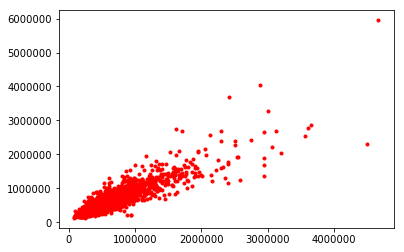

In [9]:
# create a randomforestRegressor object that will build a forest with n_estimators of trees
rf = RandomForestRegressor(n_estimators=50)

# Create the kfold split object with n_splits, shuffle=True to mix data, 
# and random_state = 0 us default numpy rng random number gen. 
kf = KFold(n_splits = 5, shuffle = True, random_state=0)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    rf.fit(X_train,y_train)
    
    ## MSE calculation. Mean squared. 
    ### 2 arrays get the difference/distance from predicted point to actual point - the error
    ### take the mean, and square that value.
    print(np.mean((rf.predict(X_test)-y_test)**2))

    
## Printing the last fit done, which was the last kfold.
### Plot will show us how closely the features and model capture the 
plt.plot(y_test, rf.predict(X_test), 'r.')

In [10]:
ts = range(1,101,10)
MSEs=[]
K=5
kf = KFold(n_splits=K, random_state=0, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    tmp = []
    for t in ts:
        rf = RandomForestRegressor(n_estimators=t)
        rf.fit(X_train,y_train)
        tmp.append(np.mean((rf.predict(X_test)-y_test)**2))
    MSEs.append(tmp)

### For each training set, let's plot the MSE as more and more trees are added to the forest.

-- We can see in the plot below that for our data set, as we reach around 15 or more trees in the forest, the MSE begins to level out without much more improvement. 

-- to speed up training time, we could reduce the number of trees added to the forest to around 20. 

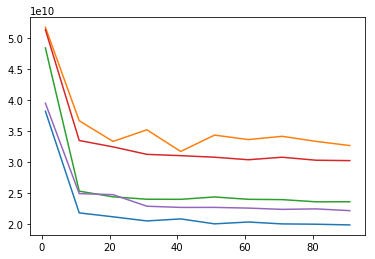

In [24]:
# more trees does not lead to overfitting
# but of course a model (e.g., a random forest CAN STILL overfit)
# ((just not because of adding more trees...))

for k in range(K):
    plt.plot(ts,MSEs[k])

## GridSearchCV - Automate some processes
-- Next we will use GridSearchCV to automate some of the processes we did manually above.
### Some features it provides:
- feature ranking based on model impact
- rank the best number of features that give the optimal score. 
    - we would expect more features to fit the data better and thus give a better score. 
    - PCA can help here if dimensionality is too large. Need to look up the cost benefit of more feature in the model. 
        

### Future Questions:  Look up pros and cons of GridSearchCV
- Since it is exhaustive, does it take longer than greedy search?
    - What about when features list grows? Exhaustive will take too long to execute.

In [28]:
### Using the GridSearchCV we can use the built in functionality of building the Cross Validation
## it allows a few lines that manages the processes for me. 

from sklearn.model_selection import GridSearchCV

# parameters = {'max_features': list(range(1,X.shape[1]+1))}
parameters = {'max_features': list(range(1,X.shape[1]+1,10))}
rf = RandomForestRegressor(n_estimators=40)
KK=5
models = GridSearchCV(estimator=rf, param_grid=parameters, cv=KK, scoring='neg_mean_squared_error')
models.fit(X, np.log(Y))

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 11, 21, 31, 41, 51, 61, 71]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [29]:
#models.best_params_
models.cv_results_

{'mean_fit_time': array([ 0.94775028,  1.49388523,  1.98678961,  2.63206606,  3.37293081,
         3.9590003 ,  4.5428555 ,  5.21704278]),
 'mean_score_time': array([ 0.06411982,  0.05803008,  0.0552454 ,  0.053616  ,  0.06141376,
         0.05751867,  0.05245008,  0.05594187]),
 'mean_test_score': array([-0.04230185, -0.04579957, -0.04787809, -0.04845169, -0.04851125,
        -0.04869371, -0.04860464, -0.04863126]),
 'mean_train_score': array([-0.00705942, -0.00748781, -0.0077245 , -0.00783197, -0.00778444,
        -0.00782235, -0.00780918, -0.00778817]),
 'param_max_features': masked_array(data = [1 11 21 31 41 51 61 71],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': ({'max_features': 1},
  {'max_features': 11},
  {'max_features': 21},
  {'max_features': 31},
  {'max_features': 41},
  {'max_features': 51},
  {'max_features': 61},
  {'max_features': 71}),
 'rank_test_score': array([1, 2, 3, 4, 5, 8, 6, 7], dtype=int32),
 's

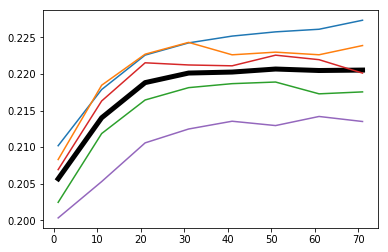

In [30]:
plt.plot(models.cv_results_['param_max_features'].data, np.sqrt(-1*models.cv_results_['mean_test_score']),linewidth=5,c='k')
for i in range(K):
    plt.plot(models.cv_results_['param_max_features'].data, np.sqrt(-1*models.cv_results_['split'+str(i)+'_test_score']))

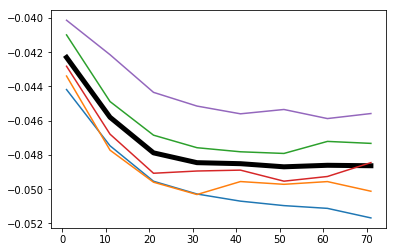

In [31]:
plt.plot(models.cv_results_['param_max_features'].data, models.cv_results_['mean_test_score'],linewidth=5,c='k')
for i in range(K):
    plt.plot(models.cv_results_['param_max_features'].data, models.cv_results_['split'+str(i)+'_test_score'])

(array([-1000000.,        0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.,  8000000.,  9000000.]),
 <a list of 11 Text xticklabel objects>)

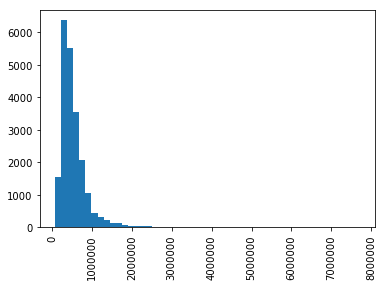

In [32]:
## Plotting prices without putting them on a standard log scale. 
plt.hist((Y), bins=50)

plt.xticks(rotation=90)

### np.log the outcome data of price, so we can see it on a scale that makes sense considering the wide range of prices possible. 

(array([ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.]),
 <a list of 8 Text xticklabel objects>)

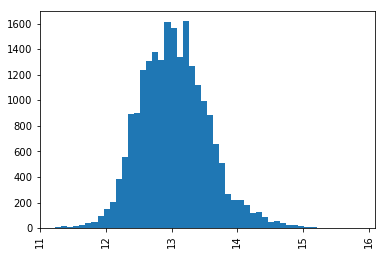

In [33]:
plt.hist(np.log(Y), bins=50)

plt.xticks(rotation=90)

In [34]:
np.sqrt(np.mean((Y - np.exp(models.best_estimator_.predict(X)))**2))


74123.250226392309

### Rank the best scoring models based on number of features. 
-- Since we are using negative MSE, the largest number of features is last as we would expect. 

In [42]:
res = pd.DataFrame({"rank" : models.cv_results_['rank_test_score'],\
                    "k" : models.cv_results_['param_max_features'].data,\
                    "MSE" : -models.cv_results_['mean_test_score']})
res.sort_values(by="rank")

,MSE,k,rank
0,0.042302,1,1
1,0.045800,11,2
2,0.047878,21,3
3,0.048452,31,4
4,0.048511,41,5
6,0.048605,61,6
7,0.048631,71,7
5,0.048694,51,8


### What feature had the largest impact on the outcome - price of home? 
-- We will rank based on feature importance 

In [43]:
fig = plt.figure(figsize=(100,200))
s=np.argsort(models.best_estimator_.feature_importances_)
plt.barh(range(len(s)),width=models.best_estimator_.feature_importances_[s])
name_np_array = np.array(label_list)
plt.tick_params(labelsize=68)
tmp=plt.yticks(range(X.shape[1]),name_np_array[s])

In [51]:
print(len(models.best_estimator_.feature_importances_[s]))
print(X.shape)
print(len(label_list))

77
(21613, 77)
77


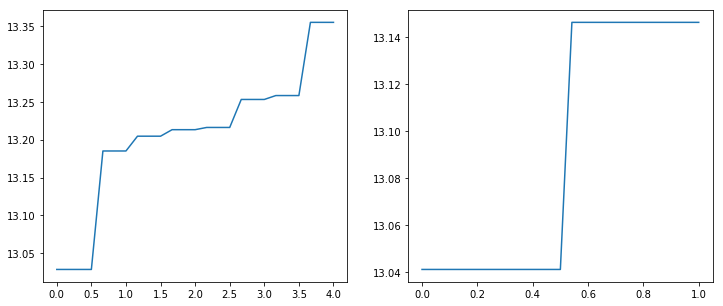

In [55]:
fig, axes = plt.subplots(1,2, figsize=[12,5])

support = np.linspace(min(X[:,-1]),max(X[:,-1]),25)
avg = []
for i in support:
    Xtmp = X.copy()
    Xtmp[:,-1] = i    
    avg.append(np.mean(models.best_estimator_.predict(Xtmp)))
    
axes[0].plot(support,avg)

support = np.linspace(min(X[:,5]),max(X[:,5]),25)
avg = []
for i in support:
    Xtmp = X.copy()
    Xtmp[:,5] = i    
    avg.append(np.mean(models.best_estimator_.predict(Xtmp)))
    
axes[1].plot(support,avg)

In [57]:
## Showing the correlation between a couple of features. 
## needs to be updated with important features and clearer purpose of graph. 
## more of a python exercise to display data.

g = np.meshgrid(np.linspace(min(X[:,-1]),max(X[:,-1]),20),np.linspace(min(X[:,5]),max(X[:,5]),20))
z = 0*g[0]
for xi in range(20):
    for yi in range(20):
        Xtmp = X.copy()
        Xtmp[:,-1] = g[0][xi,yi]
        Xtmp[:,5] = g[1][xi,yi]
        z[xi,yi] = np.mean(models.best_estimator_.predict(Xtmp))

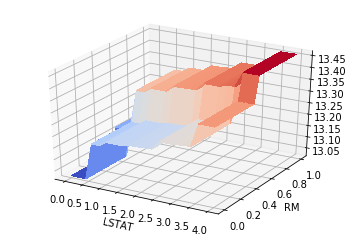

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(g[0], g[1], z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('LSTAT')
ax.set_ylabel('RM')